In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.integrate import solve_ivp
from scipy import sparse
from scipy.integrate import solve_bvp
from matplotlib.pyplot import figure
%matplotlib inline

import matplotlib.animation as animation


In [2]:
def GompertzFE(t,k,Tmax,x0):
    """ Numerically approximates the x value from IVP: 
    
    T' = k*T*ln(Tmax/T)
    
    using the Forward Euler method. 
    Parameters:
        t ((n,)ndarray): The time values
        k (float): The rate of tumor growth
        Tmax (float): The maximum Tumor Burden 
        x0 (float): The initial condition
    Returns:
        T ((n,) ndarray): The tumor burden
    """
    # Define h, X and X0 
    ht = abs(t[0] - t[1])
    # Initialize T as all zeros
    T = np.zeros(len(t))
    T[0] = x0
    # Calculate U 
    for j in range(len(t)-1):
        T[j+1] = T[j] + ht*k*T[j]*np.log(Tmax/T[j])
    return T



We modified the growth rate to near carrying capacity around 2 years after the start of untreated breast cancer. 

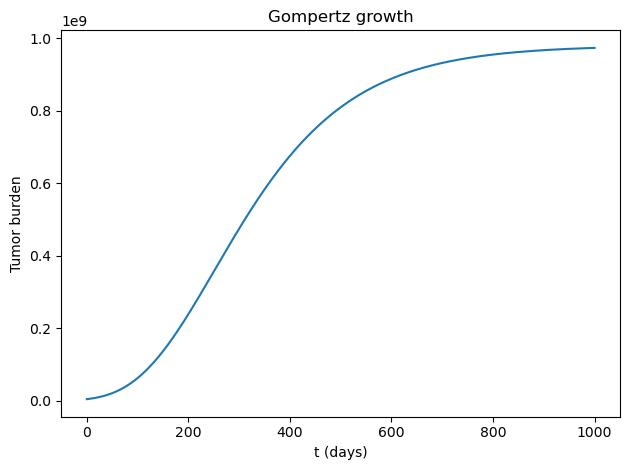

In [3]:
# define the ODE function
def gompertz(t, y, k, T_max):
    '''defines the ODE system'''
    T = y
    return np.array([k*T*np.log(T_max / T)])


# the time domain.
t_span = (0,1000)

# initial guess
y0 = np.array([4.64e6]) # nephi calculated this

# solve the system
a = 1/150
T_max = 1/(1.02e-9)
sol = solve_ivp(gompertz, t_span, y0, args=[a, T_max], max_step=0.1)

# plot
plt.plot(sol.t, sol.y[0])
plt.xlabel('t (days)')
plt.ylabel("Tumor burden")

plt.title("Gompertz growth")
plt.tight_layout()
plt.show()

Include up to 14 chemotreatments. Do 1 round each 2 weeks

In [ ]:
# define the ODE function
def breast_cancer_ode(t, y, a, T_max, mu, gamma, alpha, d, s, lam, sigma, f, g, h, p, m, j, k, q, r, chemo_times):
    """ Model for breast cancer growth dependent on chemotherapy and 2 different immune system
    cells.

    Parameters:

    
    """
    T, N, L = y
    gompertz = a*T*np.log(T_max / T)
    D = d * ((L/T)**lam)/(s + (L/T)**lam) * T

    # chemo treatment times
    chemo_term = 0
    for day in chemo_times:
        if t >= day:
            t_since_start = t - day
            ct = np.exp(-gamma*(t_since_start))
            chemo_term += mu*ct*T

    eqT = None
    if T <= 0: 
        eqT = 0
    else:
        eqT = gompertz - chemo_term - alpha*N*T - D
    eqN = sigma - f*N + N*(g*T**2)/(h + T**2) - p*N*T - 0.001*chemo_term*N
    eqL = -m*L +  L*(j*D**2)/(k+D**2) - q*L*T + r*N*T - 0.001*chemo_term*L
    return np.array([eqT, eqN, eqL])

##########
# Choose model parameters
##########
a, T_max = 1/90, 1/(1.023e-9) # gompertz parameters

mu, gamma = 0.9, 0.92 # chemotherapy parameters
t_c = 100 # time we start chemotherapy

alpha = 3.23e-7 # name for 'c' the kill rate of untrained killer cells

d, s, lam = 5.80, 2.5e-1, 1.36 # parameters for D

# parameters for derivative of N, number of killer cells
sigma, f, g, h, p = 1.3e4, 4.12e-2, 2.5e-2, 2.02e7, 1e-7

# parameters for derivative of L, the CD8 cells
m, j, k, q, r = 2e-2, 3.75e-2, 2e7, 3.42e-10, 1.1e-7

# chemo treatment days
n_treatments = 8
days_between_treatments = 21
chemo_days = np.arange(60, 60+days_between_treatments*n_treatments, days_between_treatments)


# the time domain and initial guess
n_years = 1
t_span = (0.1, 365*n_years) # 1 years
y0 = np.array([4.64e7, 2e3, 4e3]) # Tumor burden, Nk cells, CD8 cells

#############
# solve the system
#############
sol = solve_ivp(breast_cancer_ode, t_span, y0, args=[a, T_max, mu, gamma, alpha, d, s, lam, sigma, f, g, h, p, m, j, k, q, r, chemo_days], max_step=0.8)

#############
# Plot
#############
# plot tumor growth
plt.plot(sol.t, sol.y[0])
plt.xlabel('t (days)')
plt.ylabel("Tumor burden")

for x in chemo_days:
    plt.axvline(x=x, color='red', linestyle='--')


plt.title("Tumor Growth")
plt.tight_layout()
plt.show()

# plot killer  cell growth
plt.plot(sol.t, sol.y[2])
plt.xlabel('t (days)')
plt.ylabel("Killer cells")

for x in chemo_days:
    plt.axvline(x=x, color='red', linestyle='--')
plt.title("Immune Growth")
plt.tight_layout()
plt.show()

/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_24372/621512125.py:11: RuntimeWarning: invalid value encountered in log
  gompertz = a*T*np.log(T_max / T)
/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_24372/621512125.py:12: RuntimeWarning: invalid value encountered in scalar power
  D = d * ((L/T)**lam)/(s + (L/T)**lam) * T


KeyboardInterrupt: 